In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow import keras
import dataclasses
from sklearn.metrics import pairwise_distances, euclidean_distances
from sklearn.datasets import make_circles, make_blobs, make_moons
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from gensim import parsing
import re
from sklearn import datasets
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# PROBLEM 5: DBSCAN on toy-neighborhood data

In [ ]:
def calc_neighbors(data, eps):
    distances = euclidean_distances(data)
    neighbors = []
    for i in range(distances.shape[0]):
        neighbor_indices = np.where(distances[i] <= eps)[0]
        neighbor_indices = neighbor_indices[neighbor_indices != i]
        neighbors.append(neighbor_indices.tolist())
    data['neighbors'] = neighbors
    return data

In [ ]:
def dbscan(data, eps, MinPts):

    visited = set()
    cluster_id = 0
    clusters = {}

    for i, row in data.iterrows():
        if i in visited:
            continue
        neighbors = row['neighbors']
        if len(neighbors) < MinPts:
            visited.add(i)
            continue
        cluster_id += 1
        clusters[cluster_id] = [i]
        visited.add(i)
        seed_set = set(neighbors)
        seed_set.remove(i)
        while len(seed_set) > 0:
            curr_point = seed_set.pop()
            if curr_point in visited:
                continue
            visited.add(curr_point)
            curr_neighbors = data.at[curr_point, 'neighbors']
            if len(curr_neighbors) >= MinPts:
                for neighbor in curr_neighbors:
                    if neighbor not in visited:
                        seed_set.add(neighbor)
            clusters[cluster_id].append(curr_point)
    data['cluster'] = 0
    for cluster_id, members in clusters.items():
        for pt in members:
            data.at[pt, 'cluster'] = cluster_id
    return data

In [ ]:
# Load the data from csv file
data = pd.read_csv('dbscan.csv')
data['neighbors'] = data['neighbors'].apply(lambda x: [int(y) for y in x.split(',')])

In [ ]:
import dataclasses
# Execute the DBSCAN algorithm with epsilon = 7.5 and MinPts = 3
data = dbscan(dataclasses, 7.5, 3)

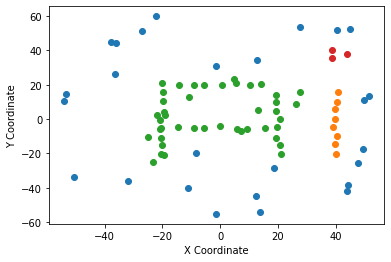

In [ ]:
import matplotlib.pyplot as plt

# Get the unique cluster ids
cluster_ids = data['cluster'].unique()

fig, ax = plt.subplots()

# Plot each cluster with a different color
for clus_id in cluster_ids:
    x = data[data['cluster'] == clus_id]['x']
    y = data[data['cluster'] == clus_id]['y']
    ax.scatter(x, y, label=f'Cluster {clus_id}')

# Add legend and labels to the plot
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Show the plot
plt.show()

# PROBLEM 6: DBSCAN on toy raw data

# Circles

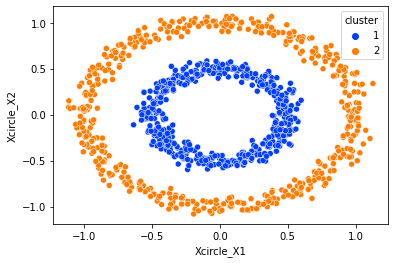

In [ ]:
circle = pd.read_csv('circle.csv')
circle_df = pd.DataFrame(circle, columns=['Xcircle_X1', 'Xcircle_X2'])

circle_df = calc_neighbors(circle_df, 0.1)

# Apply DBSCAN to the DataFrame
circle_df = dbscan(circle_df, 0.1, 5)

# Plot the clustered data
sns.scatterplot(x=circle_df['Xcircle_X1'], y=circle_df['Xcircle_X2'], hue=circle_df['cluster'], palette ='bright')

# Blobs

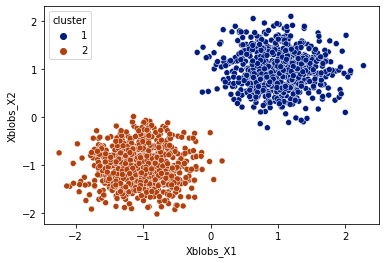

In [ ]:
blobs = pd.read_csv('blobs.csv')
blobs_df = pd.DataFrame(blobs, columns=['Xblobs_X1', 'Xblobs_X2'])

blobs_df = calc_neighbors(blobs_df, 0.31)

# Applying DBSCAN
blobs_df = dbscan(blobs_df, 0.31, 1)

# Plotting the clustered data
sns.scatterplot(x = blobs_df['Xblobs_X1'], y = blobs_df['Xblobs_X2'], hue = blobs_df['cluster'], palette ='dark')

# Moons

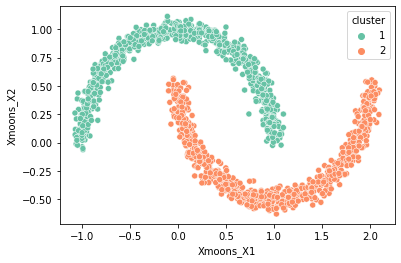

In [ ]:
moons = pd.read_csv('moons.csv')
moons_df = pd.DataFrame(moons, columns=['Xmoons_X1', 'Xmoons_X2'])

moons_df = calc_neighbors(moons_df, 0.14)

# Applying DBSCAN
moons_df = dbscan(moons_df, 0.14, 1)

# Plotting the clustered data
sns.scatterplot(x = moons_df['Xmoons_X1'], y = moons_df['Xmoons_X2'], hue = moons_df['cluster'], palette ='Set2')

# PROBLEM 7: DBSCAN on real data

# 20NG dataset

In [ ]:
import re
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\s+\w{1}\s+', '', text)
    return text

def preprocess_text(text):
    text = clean_text(text)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = text.split()
    tokens = [porter.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

newsgroups_train = fetch_20newsgroups(subset='train')

df_train = pd.DataFrame({"news" : newsgroups_train["data"] ,"class" : newsgroups_train["target"]})
df_train["cleanedText"] = df_train["news"].map(preprocess_text)
df_train.head()

,news,class,cleanedText
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,where thing subject car nntppostinghost racwam...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,guy kuo subject si clock poll final call summa...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,thomaswilli subject pb question organ purdu un...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,joe green subject weitek p organ harri comput ...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,jonathan mcdowel subject shuttl launch questio...


In [ ]:
def dbscan(X, eps, min_samples):
    # initialize the labels array as all -1 (unassigned)
    labels = np.full(X.shape[0], -1)

    # initialize a list to keep track of visited points
    visited = []

    # for each point in the dataset
    for i in range(X.shape[0]):
        if i in visited:
            continue

        # mark point as visited
        visited.append(i)

        # find all neighbors of the current point within the eps radius
        neighbors = [j for j in range(X.shape[0]) if np.linalg.norm(X[i] - X[j]) < eps]

        # if the number of neighbors is less than min_samples, mark the point as noise (-1)
        if len(neighbors) < min_samples:
            labels[i] = -1
        # otherwise, create a new cluster and assign the current point and its neighbors to it
        else:
            cluster = len(set(labels)) # new cluster label
            labels[i] = cluster
            for j in neighbors:
                if j not in visited:
                    visited.append(j)
                    labels[j] = cluster

    return labels

def calc_purity(y_true, y_pred):
    contingency_matrix = np.zeros((np.max(y_true)+1, np.max(y_pred)+1))
    for i in range(len(y_true)):
        contingency_matrix[y_true[i], y_pred[i]] += 1
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def calc_gini(y_true, y_pred):
    n = len(y_true)
    gini = 0
    for k in set(y_pred):
        p = len(y_pred[y_pred == k]) / n
        gini += p * (1 - p)
    return gini

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# selecting the first 2500 data points
df_train_sample = df_train[:2500]

# convert preprocessed text to a matrix of word counts
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(df_train_sample["cleanedText"]).toarray()

# convert the word count matrix to a matrix of TF-IDF values
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_count).toarray()

# run the DBSCAN clustering algorithm
labels = dbscan(X_tfidf, eps = 1.31, min_samples = 2)

In [ ]:
# Calculating Purity and Gini index
purity = calc_purity(df_train_sample["class"], labels)
print("Purity:", purity)

Purity: 0.7416


In [ ]:
# Calculating Gini index
gini_index = calc_gini(df_train["class"], labels)
print("Gini index:", gini_index)

Gini index: 0.2199948040177577


# FASHION dataset

In [ ]:
def dbscan(X, eps, min_samples):
    # initialize the labels array as all -1 (unassigned)
    labels = np.full(X.shape[0], -1)

    # initialize a list to keep track of visited points
    visited = []

    # for each point in the dataset
    for i in range(X.shape[0]):
        if i in visited:
            continue

        # mark point as visited
        visited.append(i)

        # find all neighbors of the current point within the eps radius
        neighbors = [j for j in range(X.shape[0]) if np.linalg.norm(X[i] - X[j]) < eps]

        # if the number of neighbors is less than min_samples, mark the point as noise (-1)
        if len(neighbors) < min_samples:
            labels[i] = -1
        # otherwise, create a new cluster and assign the current point and its neighbors to it
        else:
            num_clusters += 1 # new cluster label
            labels[i] = num_clusters
            for j in neighbors:
                if j not in visited:
                    visited.append(j)
                    labels[j] = num_clusters

    return labels

def calc_purity(y_true, y_pred):
    contingency_matrix = np.zeros((np.max(y_true)+1, np.max(y_pred)+1))
    for i in range(len(y_true)):
        contingency_matrix[y_true[i], y_pred[i]] += 1
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def calc_gini(y_true, y_pred):
    n = len(y_true)
    gini = 0
    for k in set(y_pred):
        p = len(y_pred[y_pred == k]) / n
        gini += p * (1 - p)
    return gini

In [ ]:
# Load Fashion-MNIST dataset

fashion_train_df = pd.read_csv("fashion-mnist_train.csv")

In [ ]:
X = fashion_train_df.drop(["label"],axis=1).iloc[:2500,:]
Y = list(fashion_train_df["label"])[:2500]

labels = dbscan(X, eps = 1000, min_samples = 3)

In [ ]:
print(" Purity value is : ", calc_purity(labels, Y))

 Purity value is :  0.728


In [ ]:
print("Gini impurity is : ",calc_gini(labels, Y))

Gini impurity is :  0.3981150502531492


# HouseHold dataset

In [ ]:
def DBscan(min_pts, epsilon, data):
    data = data.dropna()  # drop rows with missing values
    neighbors = find_neighbors(data, epsilon)
    core_idx = [i for i in range(len(data)) if len(neighbors[i]) >= min_pts]
    cluster = -1 * np.ones(len(data))
    current_cluster = 0
    for i in core_idx:
        if cluster[i] == -1:
            current_cluster += 1
            cluster, _ = expand_cluster(i, current_cluster, cluster, neighbors, min_pts)
    return cluster

def expand_cluster(current_idx, current_cluster, cluster, neighbors, min_pts):
    cluster[current_idx] = current_cluster
    n_neighbors = set(neighbors[current_idx])
    while n_neighbors:
        next_idx = n_neighbors.pop()
        if cluster[next_idx] == -1:
            cluster[next_idx] = current_cluster
            if len(neighbors[next_idx]) >= min_pts:
                n_neighbors.update(neighbors[next_idx])
    return cluster, []

def find_neighbors(data, epsilon):
    dist_mat = euclidean_distances(data)
    neighbors = []
    for i in range(len(data)):
        neighbors.append(set(np.where(dist_mat[i] <= epsilon)[0]))
    return neighbors

In [ ]:
df_household  = pd.read_csv('household_power_consumption.txt', delimiter=';')

In [ ]:
df_household.drop(["Date","Time"], axis=1, inplace = True)
df_household.replace("?", np.nan, inplace = True)
df_household.dropna(inplace = True)
df_household = df_household.astype(float)

In [ ]:
df_household.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,3.662,0.510,233.86,15.8,0.0,2.0,16.0


In [ ]:
df_sub = df_household.iloc[:10000,:]

In [ ]:
labels = DBscan(min_pts = 3.1, epsilon = 10, data = df_sub)

In [ ]:
sil_score = silhouette_score(df_sub, labels)
print("The silhouette score is : ", sil_score)

The silhouette score is :  0.6109953936525971


# Explain why/when it works, and speculate why/when not?

DBSCAN works well when:

1. The dataset has clusters of varying densities: Unlike traditional clustering algorithms such as K-Means, DBSCAN can identify clusters of varying densities. This is because DBSCAN defines clusters based on a threshold of minimum points within a specified radius (epsilon) rather than using a fixed number of clusters.

2. The dataset has noise: DBSCAN is capable of identifying noise (outliers) in the dataset, which it labels as individual points that do not belong to any cluster.

3. The clusters have irregular shapes: Because DBSCAN defines clusters based on density, it can detect clusters with irregular shapes such as elongated or irregularly shaped clusters.

However, DBSCAN may not work well when:

1. The dataset has clusters with similar densities: DBSCAN may struggle to differentiate between clusters with similar densities, especially if the epsilon and min_samples parameters are not appropriately set.

2. The dataset has clusters with vastly different densities: If the dataset has clusters with vastly different densities, DBSCAN may fail to detect clusters with lower densities since the algorithm's performance is sensitive to density variation.

3. The dataset has high dimensionality: As with other clustering algorithms, DBSCAN's performance decreases with high-dimensional data since the distance between points becomes less meaningful in high-dimensional spaces.

# PROBLEM 8: Hierarchical Clustering

In [ ]:
# Load MNIST dataset

mnist = fetch_openml('mnist_784')
X = mnist.data.astype(float)[:15000]
y = mnist.target.astype(int)[:15000]

# Create a hierarchical clustering object
clus = AgglomerativeClustering(n_clusters = 10, linkage = 'ward', affinity = 'euclidean')
clus.fit_predict(X)

# Calculate Gini index
gini = 0
cluster_labels = clus.labels_
for i in range(10):
    index = np.where(cluster_labels == i)[0]
    if len(index) > 0:
        p = np.bincount(y[index]).astype(float) / len(index)
        gini += len(index) / len(y) * (1 - np.sum(p ** 2))
gini = round(gini, 2)
print("Gini index:", gini)

Gini index: 0.38


In [ ]:
# Calculate purity
purity = 0
for i in range(10):
    index = np.where(cluster_labels == i)[0]
    if len(index) > 0:
        labels = y[index]
        most_common_label = np.bincount(labels).argmax()
        purity += np.sum(labels == most_common_label)
purity = round(purity / len(y), 3)
print("Purity:", purity) 

Purity: 0.703
